In [1]:
import glob
import os

import GPRutils
import vK2KGPR
import plotGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.modeling import models, fitting

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
gBand = sorted(np.array([
    474262,
    361580,
    474265,
    696547,
    484483,
    367484,
    369801,
    576863,
    791229,
    791593,
    791640,
    579816
]))
gBand

[361580,
 367484,
 369801,
 474262,
 474265,
 484483,
 576863,
 579816,
 696547,
 791229,
 791593,
 791640]

In [3]:
bands = {"g": "tab:green", "r": "tab:red", "i": "tab:purple", "z": "tab:orange"}
d = {band: [] for band in bands.keys()}

files = sorted(glob.glob("../thesis/??????"))
for file in files:
    exp = os.path.basename(file)
    fits = glob.glob(os.path.join(file, f"DES{exp}_?.fits"))[0]        
    dataC = GPRutils.loadFITS(fits)
    
    x = dataC.TV[dataC.TV["Maskf"]]["X"].value
    y = dataC.TV[dataC.TV["Maskf"]]["Y"].value
    dx = dataC.TV[dataC.TV["Maskf"]]["dX"].value
    dy = dataC.TV[dataC.TV["Maskf"]]["dY"].value
    err = dataC.TV[dataC.TV["Maskf"]]["DES variance"].value

    # Find the observed turbulence
    xi = GPRutils.getXi(np.vstack([x, y]).T, np.vstack([dx, dy]).T, rMax=0.02*u.deg)
    turbulence = xi[0]/2

    # Order the arrays based on their DES variance
    ind = np.argsort(err)
    resid_x = dx[ind]
    resid_y = dy[ind]
    measurement_error = err[ind]

    # Split arrays into groups of nStars
    nStars = 256
    resid_x = np.array_split(resid_x, len(dx)//nStars)
    resid_y = np.array_split(resid_y, len(dy)//nStars)
    measurement_error = np.array_split(measurement_error, len(measurement_error)//nStars)

    # Find RMS and median values
    RMSx = np.array([np.std(arr) for arr in resid_x])
    RMSy = np.array([np.std(arr) for arr in resid_y])
    measurement_error = np.array([np.mean(arr) for arr in measurement_error])

    # Get average RMS
    residuals_RMS = 0.5 * (RMSx**2 + RMSy**2)

    # Fit to turbulence
    p = np.poly1d([1, turbulence])

    # Get residuals
    res = residuals_RMS - p(measurement_error)
    d[dataC.band].append([measurement_error, res])

IndexError: list index out of range

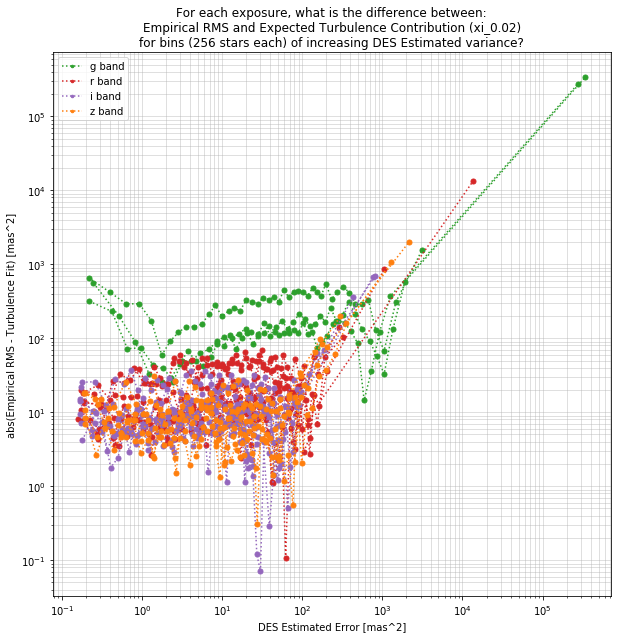

In [8]:
plt.figure(figsize=(10, 10))
title = "For each exposure, what is the difference between:"
title += "\nEmpirical RMS and Expected Turbulence Contribution (xi_0.02)"
title += "\nfor bins (256 stars each) of increasing DES Estimated variance?"
plt.title(title)

for band, c in bands.items():
#     if band == "i" or band == "z":
#         continue
    for exp in d[band]:
        plt.loglog(exp[0], np.abs(exp[1]), c=c, ls=":", marker=".", markersize=10)
    plt.plot(0, 0, c=c, ls=":", marker=".", markersize=5, label=f"{band} band")

plt.xlabel("DES Estimated Error [mas^2]")
plt.ylabel("abs(Empirical RMS - Turbulence Fit) [mas^2]")

plt.legend(loc="upper left")
plt.grid(which="both", alpha=0.5)
plt.show()

In [5]:
exp = gBand[0]
# exp = 361580
dataC = GPRutils.loadFITS(glob.glob(f"../thesis/{exp}/DES{exp}_?.fits")[0])

x = dataC.TV[dataC.TV["Maskf"]]["X"].value
y = dataC.TV[dataC.TV["Maskf"]]["Y"].value
dx = dataC.TV[dataC.TV["Maskf"]]["dX"].value
dy = dataC.TV[dataC.TV["Maskf"]]["dY"].value
err = dataC.TV[dataC.TV["Maskf"]]["DES variance"].value

# Find the observed turbulence
xi = GPRutils.getXi(np.vstack([x, y]).T, np.vstack([dx, dy]).T, rMax=0.02*u.deg)
turbulence = xi[0]/2

# Order the arrays based on their DES variance
ind = np.argsort(err)
resid_x = dx[ind]
resid_y = dy[ind]
measurement_error = err[ind]

# Split arrays into groups of nStars
nStars = 256
resid_x = np.array_split(resid_x, len(dx)//nStars)
resid_y = np.array_split(resid_y, len(dy)//nStars)
measurement_error = np.array_split(measurement_error, len(measurement_error)//nStars)

# Find RMS and median values
RMSx = np.array([np.std(arr) for arr in resid_x])
RMSy = np.array([np.std(arr) for arr in resid_y])
measurement_error = np.array([np.mean(arr) for arr in measurement_error])

# Get average RMS
residuals_RMS = 0.5 * (RMSx**2 + RMSy**2)

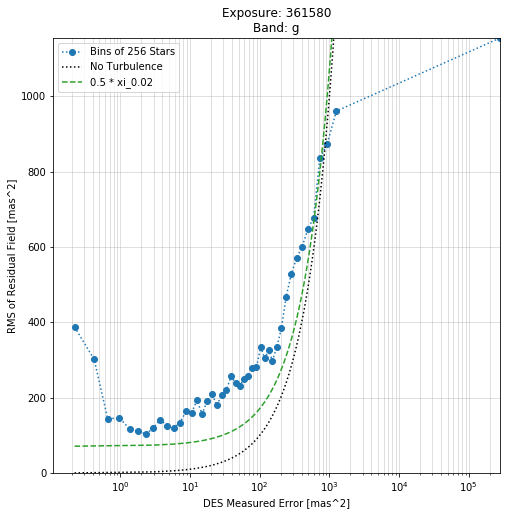

In [6]:
plt.figure(figsize=(8, 8))
plt.title(f"Exposure: {dataC.expNum}\nBand: {dataC.band}")

plt.semilogx(measurement_error, residuals_RMS, c="tab:blue", marker="o", ls=":", label=f"Bins of {nStars} Stars")

# minRMS_ind = np.argsort(residuals_RMS)[0]
# minRMS_measErr = measurement_error[minRMS_ind]
# plt.axvline(
#     x=minRMS_measErr,
#     c="k", ls="--",
#     label="Minimum RMS")

x = np.linspace(np.min(measurement_error), np.max(measurement_error), num=100000)
plt.semilogx(x, x, c="k", ls=":", label="No Turbulence")

p = np.poly1d([1, turbulence])
plt.semilogx(x, p(x), c="tab:green", ls="--", label="0.5 * xi_0.02")

plt.xlabel("DES Measured Error [mas^2]")
plt.ylabel("RMS of Residual Field [mas^2]")

plt.xlim((None, measurement_error.max()))
plt.ylim((0, residuals_RMS.max()))

plt.legend(loc="upper left")
plt.grid(which="both", alpha=0.5)
plt.show()

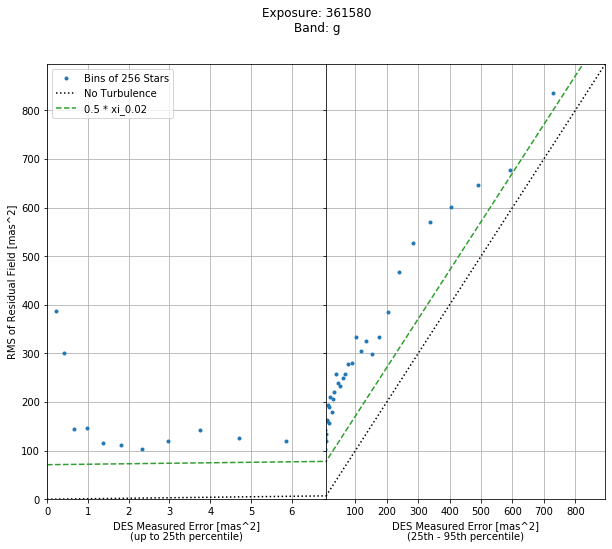

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(10, 8))
fig.suptitle(f"Exposure: {dataC.expNum}\nBand: {dataC.band}")
fig.subplots_adjust(wspace=0)

axes[0].plot(measurement_error, residuals_RMS, c="tab:blue", marker=".", ls="", label=f"Bins of {nStars} Stars")
axes[1].plot(measurement_error, residuals_RMS, c="tab:blue", marker=".", ls="", label=f"Bins of {nStars} Stars")

x = np.linspace(0, np.max(measurement_error))
axes[0].plot(x, x, c="k", ls=":", label="No Turbulence")
axes[1].plot(x, x, c="k", ls=":", label="No Turbulence")

p = np.poly1d([1, turbulence])
axes[0].plot(x, p(x), c="tab:green", ls="--", label="0.5 * xi_0.02")
axes[1].plot(x, p(x), c="tab:green", ls="--", label="0.5 * xi_0.02")

p1, p2 = 25, 95
axes[0].set_xlabel(f"DES Measured Error [mas^2]\n(up to {p1}th percentile)")
axes[1].set_xlabel(f"DES Measured Error [mas^2]\n({p1}th - {p2}th percentile)")

axes[0].set_ylabel("RMS of Residual Field [mas^2]")

axes[0].set_xlim((0, np.percentile(measurement_error, p1)))
axes[1].set_xlim((np.percentile(measurement_error, (p1, p2))))

axes[0].set_ylim((0, np.percentile(measurement_error, p2)))

axes[0].grid()
axes[1].grid()

axes[0].legend(loc="upper left")

plt.show()